THIS IS THE NOTEBOOK FOR THE DA HACKATHON - TEAM LAKSHYA

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ue21cs342aa2/sample_submission.csv
/kaggle/input/ue21cs342aa2/train.csv
/kaggle/input/ue21cs342aa2/test.csv


**APPROACH/TIMELINE -**

1. SARIMAX
2. XGB REGRESSOR
3. XGB CLASSIFIER

EXPLAINED FURTHER IN DETAIL

***ANALYSIS OF PROBLEM STATEMENT***


The Problem statement involves predicting the closing prices of the stock for the day and also suggests the best strategy for the clients, who are looking to make an informed choice for their investment decision.


The Primary goal is to predict the closing price of a specific stock. Accurate prediction is essential for investors.
Clients have three options for their investment strategy, Buy, Hold, or Sell. 

The task is to suggest the best decision based on the predicted stock price and market conditions. 
The Stock market is very sensitive to various factors, which makes it unpredictable and volatile. 


The proposed problem statement requires financial knowledge, data analysis, feature engineering and modelling to provide valuable insights and investment recommendations.

*Our task is to essentially analyse a particular stock, use models to forecast its performance and then suggest one of three actions, classify whether person must buy | sell | hold the stock.*


In [2]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor,XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
!pip install ta
!pip install pmdarima
import ta


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.3-py3-none-any.whl size=29199 sha256=249ec05417ba7bc03eebbc9703e4d17c40e9c50d15de3a0a863761e0d3a0ed9b
  Stored in directory: /root/.cache/pip/wheels/8c/3e/da/ffa819d325eea35cf8a73e24fd2c742ccd872b142aab47dc03
Successfully built ta
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.8 MB/s eta 0:00:00


## DATA PREPROCESSING

In [3]:
train_task1 = pd.read_csv('/kaggle/input/ue21cs342aa2/train.csv')
train_task2 = pd.read_csv('/kaggle/input/ue21cs342aa2/train.csv')
train_task1.head()

,id,Date,Open,Close,Volume,Strategy
0,0,2015-06-01,66.208486,75.609978,298506300,Hold
1,1,2015-06-08,64.116235,74.443331,227974800,Hold
2,2,2015-06-15,47.701942,71.140831,250670900,Buy
3,3,2015-06-22,54.754816,72.881344,223614300,Hold
4,4,2015-06-29,48.031899,66.284718,406814900,Buy


In [4]:
train_task1.describe(include='all')

,id,Date,Open,Close,Volume,Strategy
count,300.000000,300,300.000000,300.000000,3.000000e+02,300
unique,NaN,300,NaN,NaN,NaN,3
top,NaN,2015-06-01,NaN,NaN,NaN,Hold
freq,NaN,1,NaN,NaN,NaN,143
mean,149.500000,NaN,75.977813,79.430489,1.866300e+08,NaN
std,86.746758,NaN,16.158343,13.878395,7.952792e+07,NaN
min,0.000000,NaN,40.269435,47.979353,5.991330e+07,NaN
25%,74.750000,NaN,64.872395,69.689227,1.324862e+08,NaN
50%,149.500000,NaN,79.805683,82.991900,1.715536e+08,NaN
75%,224.250000,NaN,88.342927,89.719145,2.201842e+08,NaN


In [5]:
train_task1['Date'] = pd.to_datetime(train_task1['Date'],infer_datetime_format=True)
train_task2['Date'] = pd.to_datetime(train_task1['Date'],infer_datetime_format=True)

/tmp/ipykernel_20/3780718905.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  train_task1['Date'] = pd.to_datetime(train_task1['Date'],infer_datetime_format=True)
/tmp/ipykernel_20/3780718905.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  train_task2['Date'] = pd.to_datetime(train_task1['Date'],infer_datetime_format=True)


In [6]:
train_task1= train_task1.drop("Strategy", axis=1)
train_task1.set_index('Date', inplace=True)
train_task2.set_index('Date', inplace=True)


In [7]:
strategy_mapping = {'Buy': 0, 'Sell': 1, 'Hold': 2}
train_task2['Strategy'] = train_task2['Strategy'].map(strategy_mapping)

In [8]:
X_task1 = train_task1[['Open', 'Volume']]
y_task1 = train_task1[['Close']]

In [9]:
from sklearn.model_selection import train_test_split
X_train_task1, X_val_task1, y_train_task1, y_val_task1 = train_test_split(X_task1, y_task1, test_size = 0.2, random_state=None, shuffle=False)

In [10]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train_task1['Open'] = sc.fit_transform(X_train_task1[['Open']])
X_val_task1['Open'] = sc.transform(X_val_task1[['Open']])


In [11]:
X_train_task1.head()

,Open,Volume
Date,,
2015-06-01,-0.520789,298506300
2015-06-08,-0.637687,227974800
2015-06-15,-1.554786,250670900
2015-06-22,-1.160728,223614300
2015-06-29,-1.536351,406814900


In [12]:
y_train_task1.head()

,Close
Date,
2015-06-01,75.609978
2015-06-08,74.443331
2015-06-15,71.140831
2015-06-22,72.881344
2015-06-29,66.284718


## EXPLORATORY DATA ANALYSIS

In [13]:
train_task1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 2015-06-01 to 2021-02-22
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      300 non-null    int64  
 1   Open    300 non-null    float64
 2   Close   300 non-null    float64
 3   Volume  300 non-null    int64  
dtypes: float64(2), int64(2)
memory usage: 11.7 KB


In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_task1['Close'], model='multiplicative')

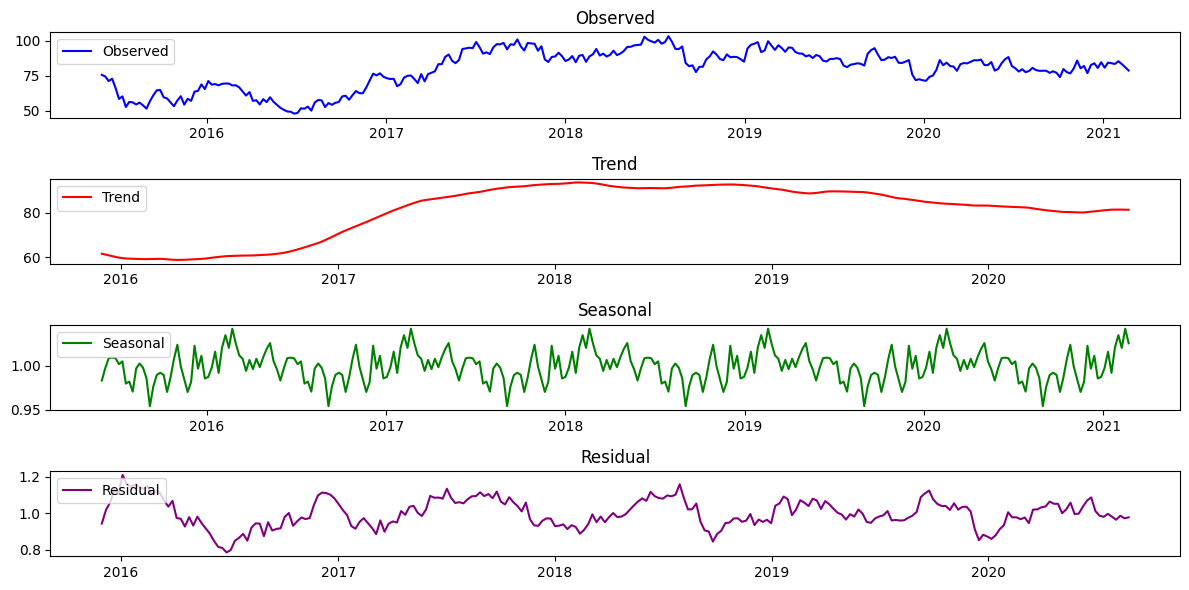

In [15]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))

plt.subplot(4, 1, 1)
plt.plot(result.observed, label='Observed', color='blue')
plt.legend(loc='upper left')
plt.title('Observed')

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend', color='red')
plt.legend(loc='upper left')
plt.title('Trend')

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.title('Seasonal')

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual', color='purple')
plt.legend(loc='upper left')
plt.title('Residual')

plt.tight_layout()
plt.show()

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
result1 = seasonal_decompose(train_task1['Close'], model='additive')

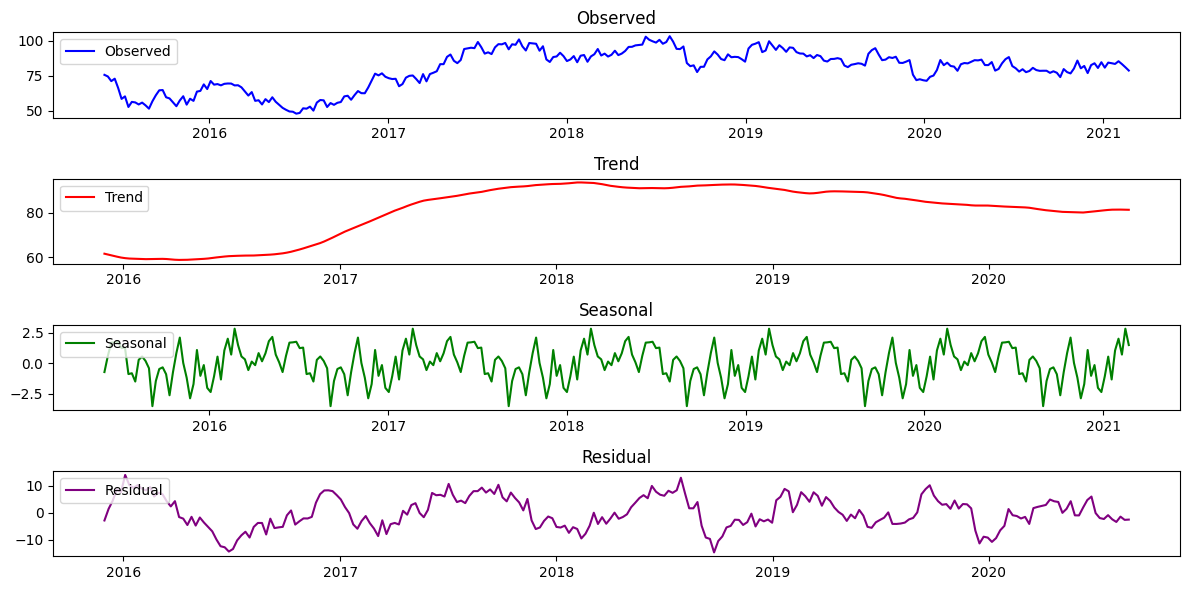

In [17]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))

plt.subplot(4, 1, 1)
plt.plot(result1.observed, label='Observed', color='blue')
plt.legend(loc='upper left')
plt.title('Observed')

plt.subplot(4, 1, 2)
plt.plot(result1.trend, label='Trend', color='red')
plt.legend(loc='upper left')
plt.title('Trend')

plt.subplot(4, 1, 3)
plt.plot(result1.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.title('Seasonal')

plt.subplot(4, 1, 4)
plt.plot(result1.resid, label='Residual', color='purple')
plt.legend(loc='upper left')
plt.title('Residual')

plt.tight_layout()
plt.show()

***INFERENCES:***

1. The data here is split into its time series components.
2. the first observation we can make , is that the seasonal plot has a repeating cyclic nature which indicates presence of **seasonality**.
3. The next observation we can make here is that, the seasonal data seems to be having a recurring pattern which has fixed spikes in the amplitude, indicating that it is an **additive** model 

***

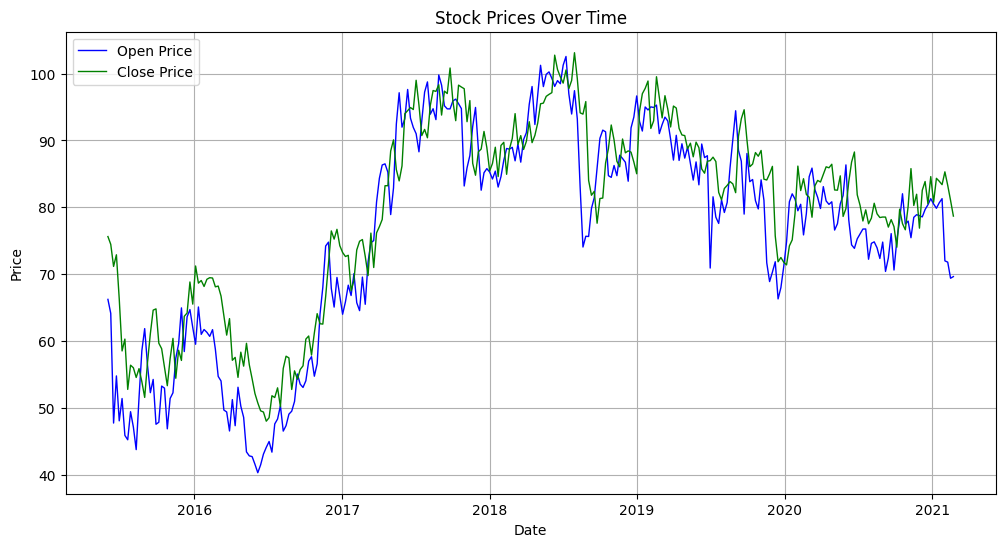

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_task1.index, train_task1['Open'], label='Open Price', color='blue', linestyle='-', linewidth=1)
plt.plot(train_task1.index, train_task1['Close'], label='Close Price', color='green', linestyle='-', linewidth=1)

plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

plt.show()


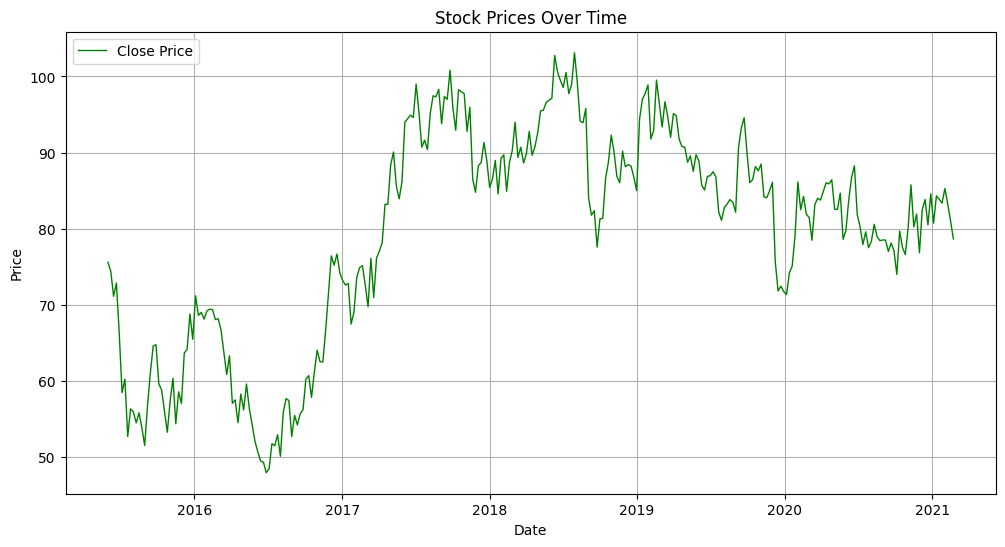

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
# plt.plot(train_task1.index, train_task1['Volume'], label='Volume', color='blue', linestyle='-', linewidth=1)
plt.plot(train_task1.index, train_task1['Close'], label='Close Price', color='green', linestyle='-', linewidth=1)

plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

plt.show()

***INFERENCES***

1. From the above we can see that the "Open" and "Close" values follow a similar pattern and have a similar trend

***

In [20]:
type(train_task1)

pandas.core.frame.DataFrame

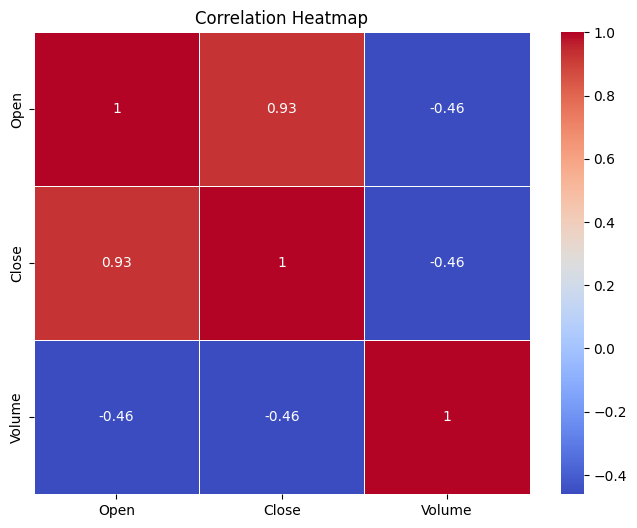

In [21]:
correlation_matrix = train_task1[['Open', 'Close', 'Volume']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


***INFERENCES***

1. As we can see from the above correlation plot, there is a very high positive linear correlation between the "Open" and "Close" columns in the dataset.
2. This provides us a key metric , which we will make use of in determining whether or not a model is able to provide viable accuracy.

***

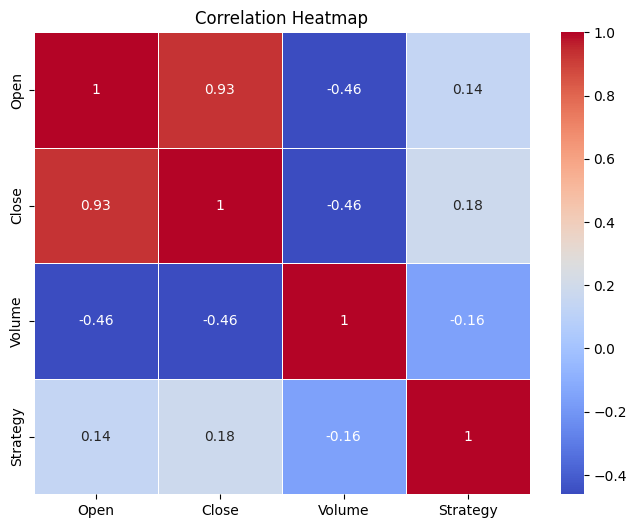

In [22]:
correlation_matrix = train_task2[['Open', 'Close', 'Volume', 'Strategy']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

***INFERENCES***

1. Similarly , when we plot for the task2 training set, we can see that there is a similar correlation story here as well.
2. In addition, the encoded values of do not really show any linear correlation with any of the columns.

***

In [23]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

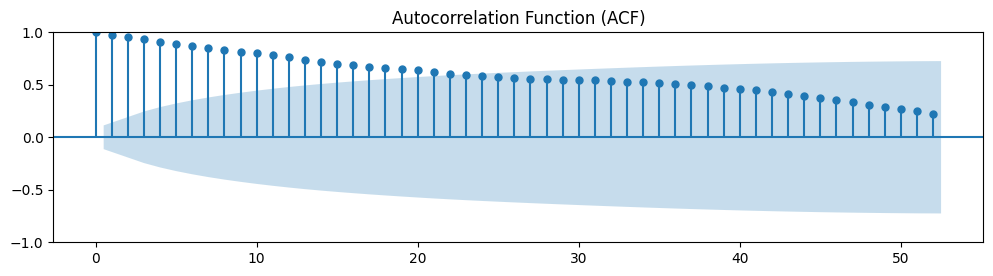

In [24]:
plt.figure(figsize=(12, 6))

plt.subplot(211)
plot_acf(train_task1['Close'], lags=52, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')



plt.show()

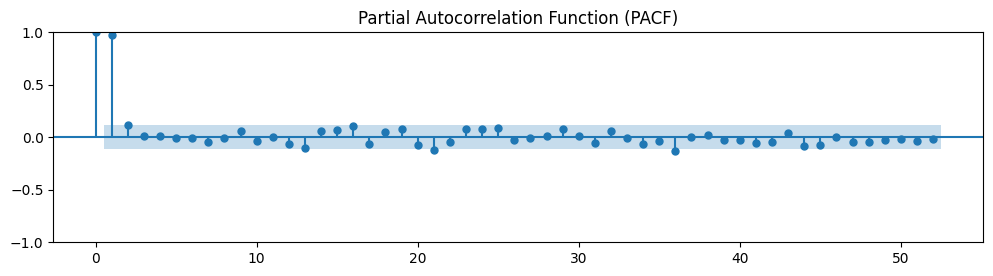

In [25]:
plt.figure(figsize=(12, 6))
plt.subplot(212)
plot_pacf(train_task1['Close'], lags=52, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

***INFERENCES***

1. From the above ACF - PACF plots plotted on un-differenced data, we can see that:
   1. There is an exponential decreaseing trend in the ACF plot indicating that there is presence of seasonality or a long-term trend in the data.
   2. There are two highly correlated lag values in the PACF plot, determining that upto 2 lags, there exists correlation.
2. Next we shall plot and see on differenced data.

***

In [26]:
def check_stationarity(data):
    
    result = adfuller(data)
    p_value = result[1]

    print("ADF Test p-value:", p_value)
    if p_value <= 0.05:
        print("The data is stationary.")
    else:
        print("The data is non-stationary.")

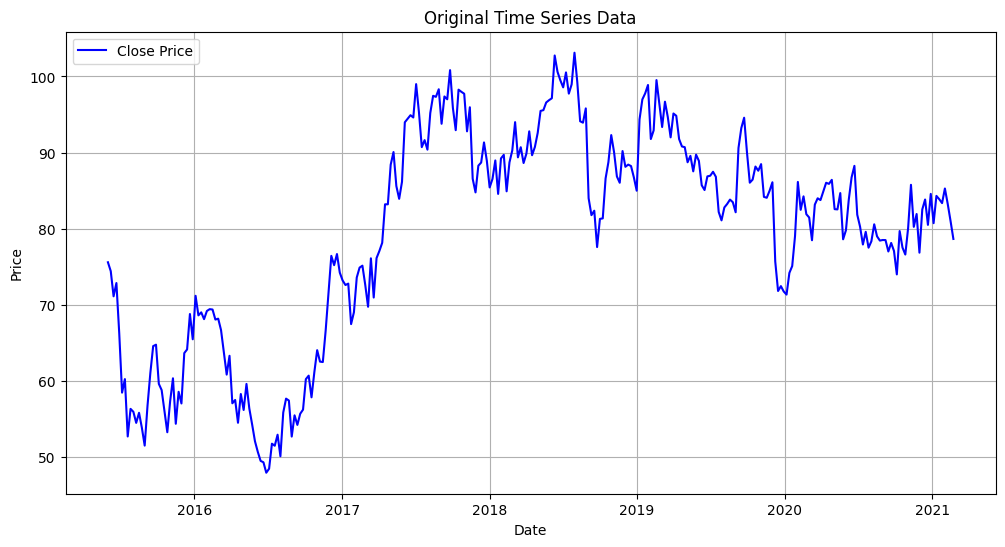

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(train_task1.index, train_task1['Close'], label='Close Price', color='blue', linestyle='-')
plt.title('Original Time Series Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


In [28]:

check_stationarity(train_task1['Close'])
train_task1['Close_Differenced'] = train_task1['Close'].diff(1)

ADF Test p-value: 0.37649446979222034
The data is non-stationary.


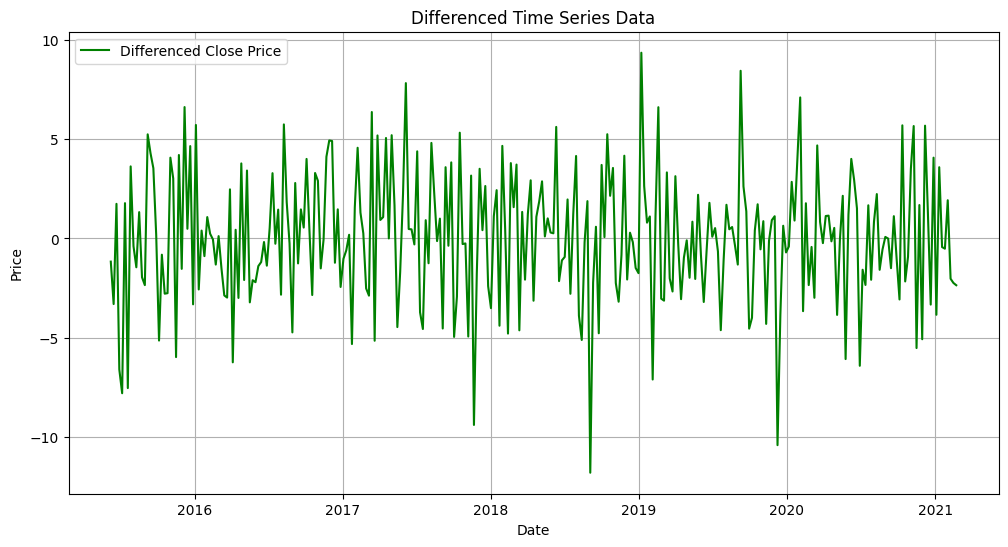

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(train_task1.index, train_task1['Close_Differenced'], label='Differenced Close Price', color='green', linestyle='-')
plt.title('Differenced Time Series Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [30]:
print(train_task1["Close_Differenced"])

Date
2015-06-01         NaN
2015-06-08   -1.166647
2015-06-15   -3.302500
2015-06-22    1.740512
2015-06-29   -6.596626
                ...   
2021-01-25   -0.516252
2021-02-01    1.921405
2021-02-08   -2.028450
2021-02-15   -2.239626
2021-02-22   -2.354819
Name: Close_Differenced, Length: 300, dtype: float64


In [31]:
train_task1["Close_Differenced"] = train_task1["Close_Differenced"].replace([np.inf, -np.inf], np.nan).fillna(0)

In [32]:
check_stationarity(train_task1['Close_Differenced'])

ADF Test p-value: 0.0
The data is stationary.


***INFERENCES***

1. In the above cells, we have used the **AD FULLER** test to check for stationarity of data.
2. We observe that the data is NON-STATIONARY as the p-value is greater than 0.05 ( the significance level).
3. To convert it into stationary data, we apply first-order **DIFFERENCING** to the "close" column.
4. After differencing, we once again check the p-value using the AD Fuller test. We obtain a low p-value indicating the data has now become stationary.
5. Also, there is one NAN value which is obtained after first order differencing, we replace it with 0.

***

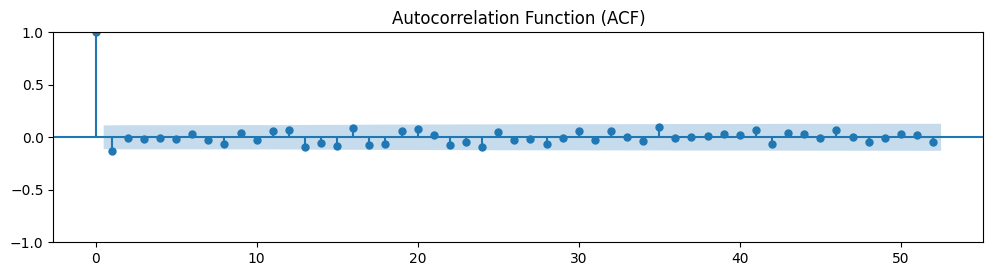

In [33]:
plt.figure(figsize=(12, 6))

plt.subplot(211)
plot_acf(train_task1.Close_Differenced, lags=52, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.show()

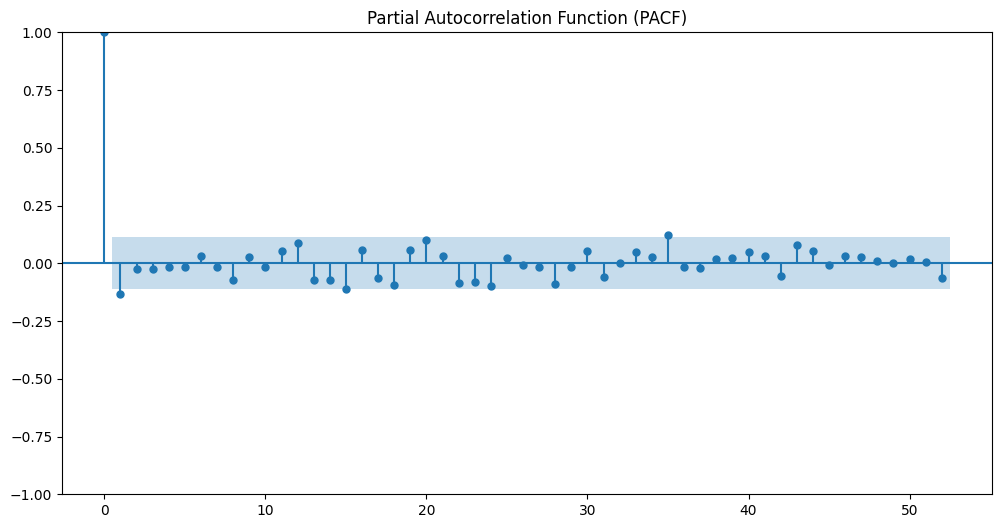

In [34]:
plt.figure(figsize=(12, 6))
# plt.subplot(212)
plot_pacf(train_task1['Close_Differenced'], lags=52, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

***INFERENCES***

1. From the above ACF-PACF plots, we can conclude that the values are as follows:
2. p = 1 ; q = 1 ; d = 1.

***

In [35]:
import pmdarima as pm
from pmdarima import auto_arima
model = pm.auto_arima(train_task1['Close_Differenced'], seasonal=True, stepwise=False, suppress_warnings=True)
# acf_values, pacf_values = pm.acf_pacf(model)

model.summary()

# print(f'Best ARIMA Model: {model.summary()}')
# print(f'ACF Values:\n{acf_values}')
# print(f'PACF Values:\n{pacf_values}')

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  300
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -777.143
Date:                Wed, 01 Nov 2023   AIC                           1560.286
Time:                        18:12:11   BIC                           1571.397
Sample:                    06-01-2015   HQIC                          1564.732
                         - 02-22-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0115      0.162      0.071      0.943      -0.306       0.329
ma.L1         -0.1362      0.058     -2.350      0.019      -0.250      -0.023
sigma2        10.4124      0.776     13.426      0.000       8.892      11.932
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.94
Prob(Q):                              0.98   Prob(JB):                         0.14
Heteroskedasticity (H):               0.86   Skew:                            -0.18
Prob(H) (two-sided):                  0.44   Kurtosis:                         3.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

***INFERENCES***

The above usee of PMDARIMA hasnt been very fruitful as we later on will see, these values , pose a very high AIC value. We know that Lower the AIC, better it is. Thus we refrain from using PMDARIMA.

***

In [36]:
train_task1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 2015-06-01 to 2021-02-22
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 300 non-null    int64  
 1   Open               300 non-null    float64
 2   Close              300 non-null    float64
 3   Volume             300 non-null    int64  
 4   Close_Differenced  300 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 14.1 KB


In [37]:
train_task2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 2015-06-01 to 2021-02-22
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        300 non-null    int64  
 1   Open      300 non-null    float64
 2   Close     300 non-null    float64
 3   Volume    300 non-null    int64  
 4   Strategy  300 non-null    int64  
dtypes: float64(2), int64(3)
memory usage: 14.1 KB


***INFERENCES***

1. Thus, at the end of the Exploratory Data Analysis we have obtained various insights on the data.
2. We have also transformed the data to our needs.

***
***

## MODEL 1 - FORECASTING - SARIMAX

We go ahead and implement the best statistical model for time series forecasting.
reasons:

-> seasonality present in the data

-> exponentially decreasing ACF plot indicating trend

-> existence of important exogenous variables.

In [38]:
train_data_task1 = pd.read_csv('/kaggle/input/ue21cs342aa2/train.csv')

In [39]:
train_size_task1 = int(0.8 * len(train_data_task1))
train_set_task1 = train_data_task1.iloc[:train_size_task1]
validation_set_task1 = train_data_task1.iloc[train_size_task1:]


In [40]:
def feature_engineering_task1(data):
    data['Open_Lag1'] = data['Open'].shift(3)
    data['Volume_Lag1'] = data['Volume'].shift(-2)

    data['Date'] = pd.to_datetime(data['Date'])

    data['Day'] = data['Date'].dt.day
    data['Month'] = data['Date'].dt.month
    data['Year'] = data['Date'].dt.year

    data['Rolling_Mean_Open'] = data['Open'].rolling(window=4).mean()

    data['EMA_10'] = ta.trend.ema_indicator(data['Open'], window=13)

    data['RSI'] = ta.momentum.RSIIndicator(data['Open']).rsi()

    data['MACD'] = ta.trend.MACD(data['Open']).macd()


    return data

In [41]:
import warnings
warnings.simplefilter(action = 'ignore', category = Warning)
train_set_task1 = feature_engineering_task1(train_set_task1)
validation_set_task1 = feature_engineering_task1(validation_set_task1)



In [42]:
X_train_task1 = train_set_task1[['Open_Lag1', 'Volume_Lag1', 'Month','Year','Rolling_Mean_Open', 'EMA_10', 'RSI', 'MACD']]
y_train_task1 = train_set_task1['Close']
X_val_task1 = validation_set_task1[['Open_Lag1', 'Volume_Lag1', 'Month','Year','Rolling_Mean_Open', 'EMA_10', 'RSI', 'MACD']]
y_val_task1 = validation_set_task1['Close']


In [43]:
def fill_missing_with_mean(data_frame):
    data_frame.fillna(data_frame.mean(), inplace=True)
fill_missing_with_mean(X_train_task1)
fill_missing_with_mean(X_val_task1)

In [44]:
import warnings
warnings.simplefilter(action = 'ignore', category = Warning)
 
from statsmodels.tsa.statespace.sarimax import SARIMAX
 
model = SARIMAX(y_train_task1, 
                exog= X_train_task1,
                order = (2, 0, 6), 
                seasonal_order = (2, 0, 6, 7),
                enforce_stationarity = False, 
                enforce_invertibility = False)
 
result = model.fit(maxiter = 500, method = 'nm')

In [45]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                  240
Model:             SARIMAX(2, 0, 6)x(2, 0, 6, 7)   Log Likelihood                -389.807
Date:                           Wed, 01 Nov 2023   AIC                            829.614
Time:                                   18:12:22   BIC                            910.920
Sample:                                        0   HQIC                           862.547
                                           - 240                                         
Covariance Type:                             opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Open_Lag1             0.6714      0.004    161.488      0.000       0.663       0.680
Volume_Lag1       -4.499e-09   2.17e-09     -2.072      0.038   -8.75e-09   -2.44e-10
Month                -0.0710      0.001    -87.141      0.000      -0.073      -0.069
Year                  0.0094      0.001     14.071      0.000       0.008       0.011
Rolling_Mean_Open     0.1281      0.005     28.368      0.000       0.119       0.137
EMA_10                0.0450      0.004     10.937      0.000       0.037       0.053
RSI                  -0.0495      0.013     -3.825      0.000      -0.075      -0.024
MACD                  0.2010      0.004     56.941      0.000       0.194       0.208
ar.L1                -0.4140      0.000  -2146.423      0.000      -0.414      -0.414
ar.L2                 0.1012      0.000    837.339      0.000       0.101       0.101
ma.L1                 0.4394      0.000   2613.153      0.000       0.439       0.440
ma.L2                -0.0363   9.92e-05   -366.012      0.000      -0.036      -0.036
ma.L3                 0.1000      0.000    251.737      0.000       0.099       0.101
ma.L4                 0.0522      0.000    236.028      0.000       0.052       0.053
ma.L5                 0.0441   4.59e-05    961.449      0.000       0.044       0.044
ma.L6                -0.0495      0.000   -185.125      0.000      -0.050      -0.049
ar.S.L7               0.2832      0.000   1199.267      0.000       0.283       0.284
ar.S.L14             -0.1420      0.000   -679.298      0.000      -0.142      -0.142
ma.S.L7              -0.2957   4.71e-05  -6284.306      0.000      -0.296      -0.296
ma.S.L14              0.1221      0.000    406.273      0.000       0.122       0.123
ma.S.L21             -0.1426      0.000   -507.690      0.000      -0.143      -0.142
ma.S.L28              0.0395      0.001     75.534      0.000       0.039       0.041
ma.S.L35             -0.1596      0.000   -692.379      0.000      -0.160      -0.159
ma.S.L42              0.0008      0.001      1.547      0.122      -0.000       0.002
sigma2                3.4428   6.14e-05   5.61e+04      0.000       3.443       3.443
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.94
Prob(Q):                              0.96   Prob(JB):                         0.23
Heteroskedasticity (H):               1.70   Skew:                             0.28
Prob(H) (two-sided):                  0.04   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.6e+21. Standard errors may be unstable.
"""

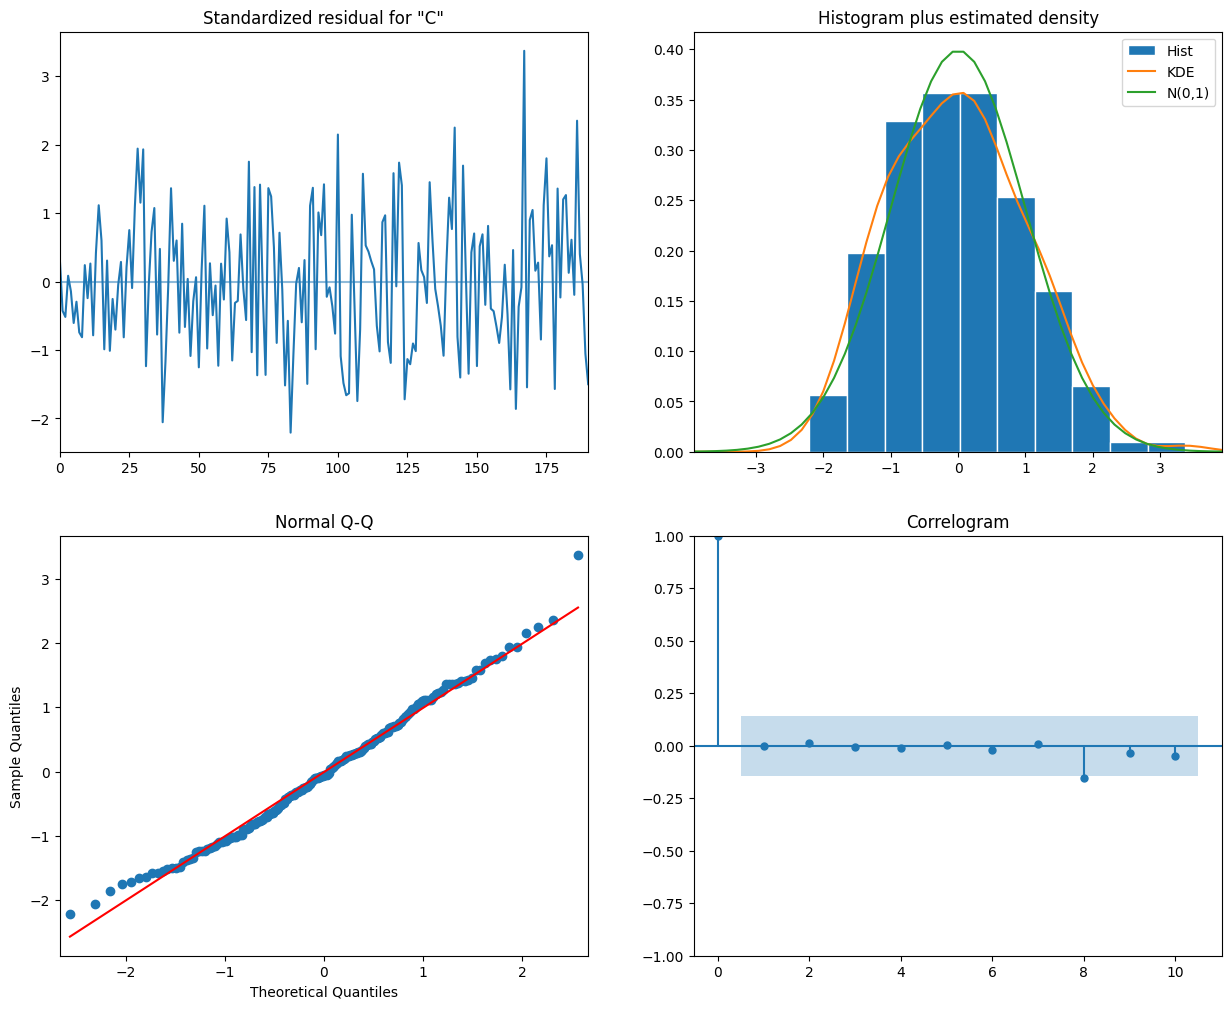

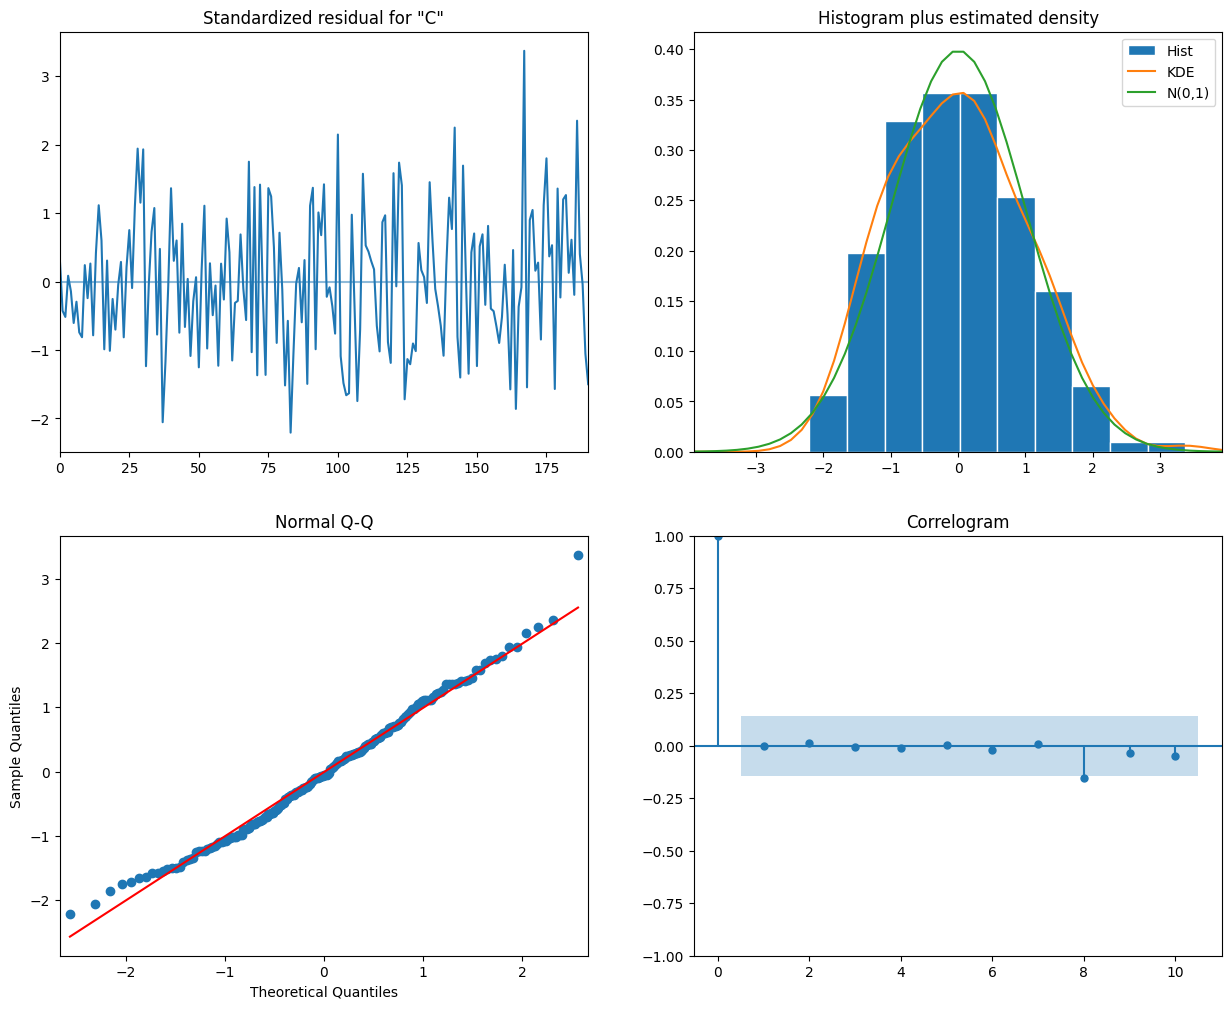

In [46]:
result.plot_diagnostics(figsize=(15, 12))

***INFERENCES***

THE ABOVE PLOTS ARE VERY CONVINCING IN THE METRICS THE DISPLAY.

RESIDUALS ARE NOT CORRELATED

RESIDUALS FOLLOW NORMAL DISTRIBUTION

THUS THE DIAGNOSTICS METHOD CONFIRMS THAT SARIMAX CAN BE USED FOR THIS DATASET

***

In [47]:
start = len(y_train_task1)
 
# and it will end at the end of the test
end = len(y_train_task1) + len(y_val_task1) - 1
  
# apply the method predict
y_pred_val_task1 = result.predict(start, end, exog =X_val_task1 )
# y_pred_val_task1
# y_pred_val_task1 = np.array(y_pred_val_task1)

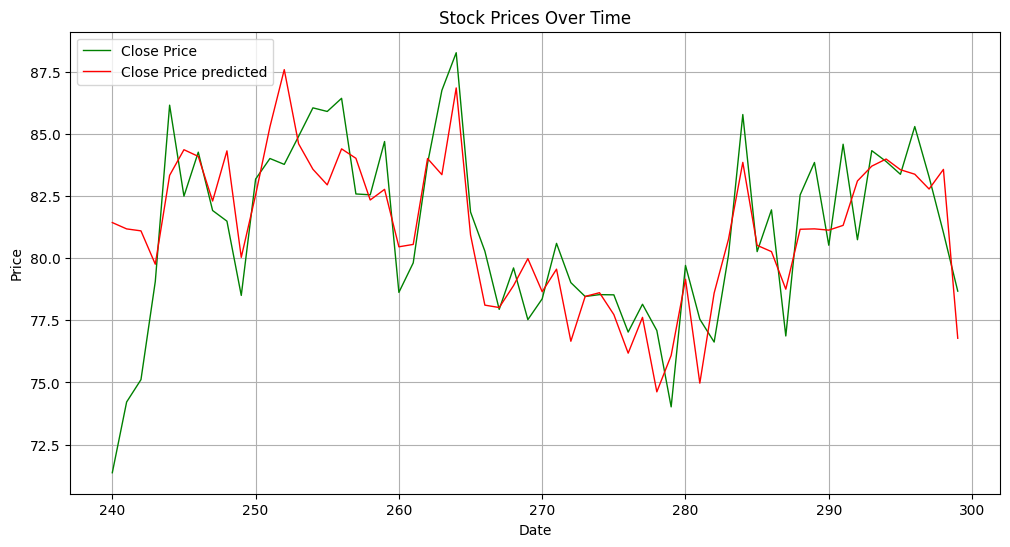

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
# plt.plot(X_val_task1.index, X_val_task1['Open_Lag1'], label='Open Price', color='blue', linestyle='-', linewidth=1)
plt.plot(y_val_task1.index, y_val_task1, label='Close Price', color='green', linestyle='-', linewidth=1)
plt.plot(y_pred_val_task1.index, y_pred_val_task1, label='Close Price predicted', color='red', linestyle='-', linewidth=1)

plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

plt.show()

In [49]:
def calculate_smape(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
smape_val_task1 = calculate_smape(y_val_task1, y_pred_val_task1)
smape_val_task1

0.010793486169026983

### **Feature Engineering:**

-> Feature engineering is essential for improving the predictive performance of machine learning models, especially in time series analysis. We have added the following features as a part of Feature engineering:

1. **Open_Lag1:**

It helps capture the value of the 'Open' price from three time periods ago. Lag features can help the model capture historical patterns and dependencies.

2. **Volume_Lag1:**

It captures the value of the 'Volume' from two time periods in the future. Lag features can be used to capture temporal relationships.We have shifted lag values based on the graph that we had plotted. Another reason why we have used **-2**  is because, from the correllogram, we can see that the correlation coefficient between the  Close and volume columns are negatively correlated. that is why we have used negative sign for the lag.

3. **Date:**

The 'Date' feature is converted to a datetime object using pandas, allowing for time-based analysis and extraction of date-related attributes such as day, month, and year. In our code we extract and use the **Month and Year** respectively.

4. **Rolling_Mean_Open:**

This feature calculates the rolling mean of the 'Open' price with a window of 4 time steps. The main use of Rolling means is to smooth out short-term fluctuations and capture underlying trends. We have experimented various values for rolling meanand settled with monthly window size.**Here it is monthly as the value 4 indicates 4 weeks.** Rolling mean is also known as SMA, which calculates the average of a specified number of consecutive data points, giving equal weight to each point within the specified window.


5. **EMA_10 (Exponential Moving Average):**

Exponential moving averages give more weight to recent values. The EMA with a window of 13 is used on the 'Open' price. It can capture short- to mid-term trends and smooth out noise. Here we use 13 as the EMA value because the value **13 takes into account quarterly information.**

6. **RSI (Relative Strength Index):**

RSI measures the momentum of the 'Open' price. It can help identify overbought or oversold conditions and potential trend reversals.

7. **MACD (Moving Average Convergence Divergence):**

MACD is a trend-following indicator that shows the relationship between two moving averages of the 'Open' price. It can help identify potential changes in the trend.We believe this can provide valuable information and improve the model's ability to generalize from historical data to future predictions.


## Conclusion From Model 1

We have been able to achieve an amazing SMAPE score of 0.0107 on the validation set with SARIMAX. 

we had also used PMDARIMA to determine the best values of PDQs, but unfortunately, it did not yield better SMAPE scores.

Another suspect was that , due to the extremely close plot between OPEN and CLOSE (PREDICTED), there might be overfitting which could be taking place.

Also, Further on, this SARIMAX code coupled with the Following XGBOOST CLASSIFIER, wasnt able to give a total score of less than 20 on the public leaderboard. Hence we move onto our next model  - XGBOOST REGRESSOR!

## OVERVIEW FOR THE XGBOOST REGRESSOR-CLASSIFIER COMBO:
***WHAT EXACTLY HAVE WE DONE?***

***STEPS***

**FIRST**

CREATE A TRAIN VALIDATION SPLIT USING TRAIN.CSV

**SECOND**

TRAIN AN XGBREGRESSOR WITH VARIOUS ENGINEERED FEATURES AND TUNED HYPERPARAMETERS

**THIRD**

CALCULATE SMAPE SCORE OF THE MODEL ON VALIDATION SET

**FOURTH**

FEED THE XGBREGRESSOR WITH ALL OF THE TRAIN.CSV DATA ; WE ALSO DEFINE A NEW FUNCTION FOR FEATURE ENGINEERING WHICH ALLOWS US TO MODIFY ENGINEERED FEATURES WITH IMPROOVED CUSTOMIZABILITY

**FIFTH**

APPEND THE PREDICTED COLUMNS TO THE TEST SET UPON READING TEST.CSV

**SIXTH**

SIMILAR TO STEPS 1-4 ; CHECK ACCURACY OF XGBCLASSIFIER ON SPEACIALLY HYPERTUNED PARAMETERS AND ENGINEERED FEATUES.

**SEVENTH**

TRAIN THE ENTIRE TRAIN SET ON THE CLASSIFIER, WE DEFINE ANOTHER FEATURE ENGINEERING FUNCTION TO ENHANCE CUSTOMIZABILITY

**EIGHTH**

MAKE PREDICTIONS ON THE TEST SET AND SUBMIT A CSV FILE.

**SUMMARY**

1 * XGBREGRESSOR

1 * XGBCLASSIFIER

4 * FEATURE ENGINEERING FUNCTIONS (2 PER MODEL)


**MAIN REASONS FOR USING XGBOOST -**

XGBOOST IS ABLE TO PROVIDE MAXIMUM CORRELATION BETWEEN OPEN AND PREDICTED CLOSING VALUE, SIMILAR TO THE PATTERN SEEN ON THE TRAIN.CSV, WHERE OPEN AND CLOSE HAVE A POSITIVE LINEAR CORRELATION OF 0.93.

IT IS ABLE TO PROVIDE A VERY CONVINCING SMAPE SCORE ON THE VALIDATION SET, HOPEFULLY IT IS NOT OVER FITTING :)

ALSO, XGBOOST IN IN ITSELF AN ENSEMBLE METHOD, AS WE ALL KNOW ENSEMBLE METHODS ARE INDEED POWERFULL IN SUPERVISED ML.

LASTLY, IT IS THIS COMBINATION THAT GAVE US A SCORE OF 14.04 ON THE PUBLIC LEADERBOARD.

***OTHER COMMENTS:***

WE HAVE USED XGB AS OUR FINAL MODEL BECAUSE IT IS ABLE TO MATH UNDERLYING PATTERNS (PEAKS AND TROUGHS) AND ABLE TO GENERALIZE (HORIZONTAL FLAT LINES) WELL AT THE SAME TIME.

OUR REASONING FOR FEATURE ENGINEERING REMAINS THE SAME AS THE REASON PROVIDED IN THE SARIMAX CODE.

WE TRIED TO IMPLEMENT A STACKINGREGRESSOR FUNCTION FROM SCIKITLEARN (A MODIFIED VERSION OF VOTING REGRESSOR) USING A MIX OF SARIMAX AND XGBREGRESSOR, BUT WASNT PROVING TO BE VERY REWARDING ON THE PUBLIC LEADERBOARD.(THE SCORE WITH 16 ON IN OUR SUBMISSIONS)



## MODEL 2 - XGBOOST REGRESSOR - FORECASTING

We perform a similar data intake, preprocessing and feature engineering in the XGBOOST REGRESSOR as well.

We will code the same below:

In [50]:
train_data_task1 = pd.read_csv('/kaggle/input/ue21cs342aa2/train.csv')


In [51]:
train_size_task1 = int(0.8 * len(train_data_task1))
train_set_task1 = train_data_task1.iloc[:train_size_task1]
validation_set_task1 = train_data_task1.iloc[train_size_task1:]


In [52]:
def feature_engineering_task1(data):
    data['Open_Lag1'] = data['Open'].shift(3)
    data['Open_Lag2'] = data['Open'].shift(4) 
    data['Open_Lag3'] = data['Open'].shift(2)

    data['Volume_Lag1'] = data['Volume'].shift(-2)


    data['Date'] = pd.to_datetime(data['Date'])

    data['Day'] = data['Date'].dt.day
    data['Month'] = data['Date'].dt.month
    data['Year'] = data['Date'].dt.year

    data['Rolling_Mean_Open'] = data['Open'].rolling(window=4).mean()
    data['Rolling_Mean_Open_2'] = data['Open'].rolling(window=13).mean()
    data['Rolling_Mean_Open_3'] = data['Open'].rolling(window=26).mean()

    data['EMA_10'] = ta.trend.ema_indicator(data['Open'], window=13)
    data['EMA_10_2'] = ta.trend.ema_indicator(data['Open'], window=4)

    data['RSI'] = ta.momentum.RSIIndicator(data['Open']).rsi()

    data['MACD'] = ta.trend.MACD(data['Open']).macd()

    # Add the difference between current and previous Open value
    data['Open_Diff'] = data['Open'] - data['Open'].shift(1)
    data['Open_Diff2'] = data['Open'].shift(1) - data['Open'].shift(2)
    data['Volume_Change'] =  data['Volume'].shift(1) - data['Volume']

    return data


    # return data

In [53]:
import warnings
warnings.simplefilter(action = 'ignore', category = Warning)
train_set_task1 = feature_engineering_task1(train_set_task1)
validation_set_task1 = feature_engineering_task1(validation_set_task1)

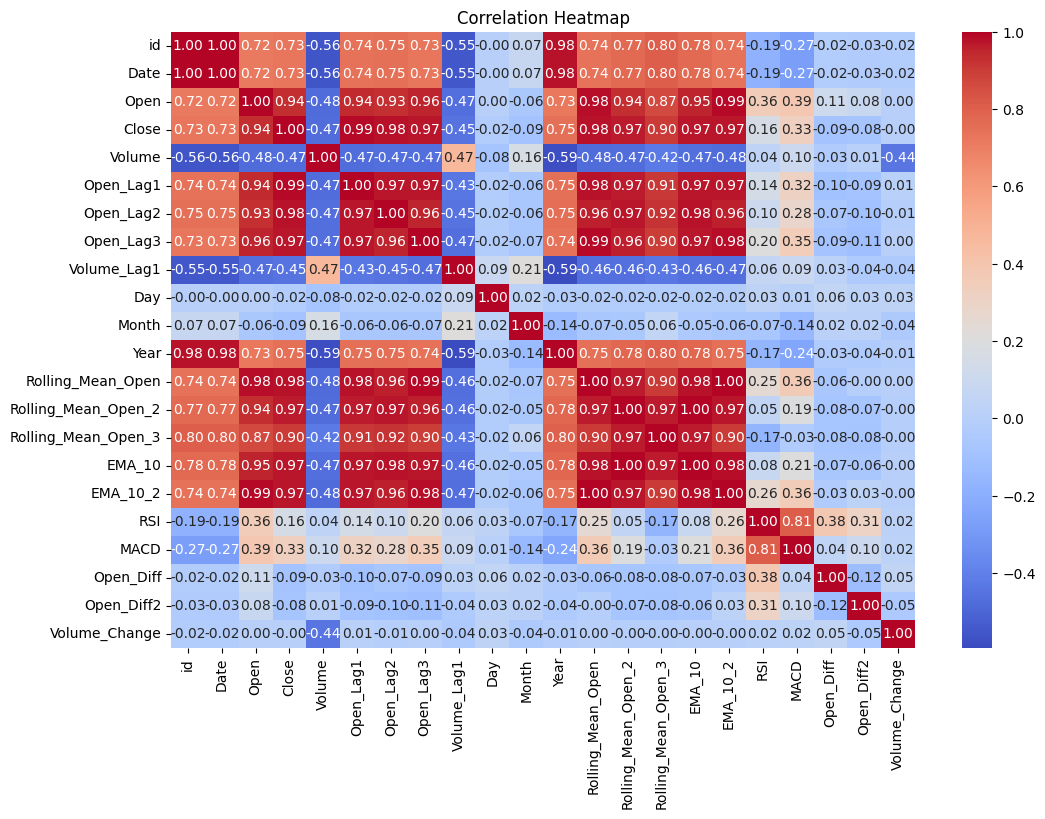

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `data` is your DataFrame after applying the `feature_engineering_task1` function
train_set_corr =train_set_task1.drop("Strategy", axis = 1)
corr_matrix = train_set_corr.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 8))

# Create a heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=False, ax=ax)

# Set the title
plt.title("Correlation Heatmap")

# Show the plot
plt.show()


We are choosing the relevant features for the X_train_task1 according to this correlation plot.


In [55]:
X_train_task1 = train_set_task1[['Open_Lag1', 'Open_Lag2','Open_Lag3','EMA_10_2' , 'Rolling_Mean_Open_2','Rolling_Mean_Open_3','Year', 'Open_Diff','Rolling_Mean_Open', 'EMA_10']]
y_train_task1 = train_set_task1['Close']
X_val_task1 = validation_set_task1[['Open_Lag1', 'Open_Lag2','Open_Lag3','EMA_10_2' , 'Rolling_Mean_Open_2','Rolling_Mean_Open_3','Year', 'Open_Diff','Rolling_Mean_Open', 'EMA_10']]
y_val_task1 = validation_set_task1['Close']


In [56]:
xgb_regressor_task1 = XGBRegressor(n_estimators=50,max_depth=3,eval_metric = 'mape',learning_rate=0.1,objective='reg:squarederror')
xgb_regressor_task1.fit(X_train_task1, y_train_task1)
y_pred_val_task1 = xgb_regressor_task1.predict(X_val_task1)


***WHY ABOVE PARAMETERS WORK??***

1. **n_estimators**:
   
The XGBoost classifier will build 50 decision trees during training, due to which it is better able to capture trends and pattenrs in the data.

2. **eval_metric**:
   
'mape' is used here for telling the model to reduce the MEAN ABSOLUTE PERCENTAGE ERROR, which is similar to SMAPE, our aim. 

3. **max_depth**:

This parameter controls the maximum depth of each decision tree. A higher value allows the trees to be deeper and potentially more complex. Setting it to 4 limits the depth to 4 levels. This is set to 4 limiting the chances of overfitting despite the large number of estimators used.



4. **learning_rate**:
Learning rate is a hyperparameter that controls the step size at each iteration while moving toward a minimum of a loss function. We have set it as 0.1 

5. **objective**:

The 'objective' parameter defines the learning task and the corresponding objective function to be optimized. 'reg:squarederror'  indicates that the regressor is used for calculating the squared error and minimising it.


***

In [57]:
def calculate_smape(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
smape_val_task1 = calculate_smape(y_val_task1, y_pred_val_task1)
smape_val_task1

0.012108578748380377

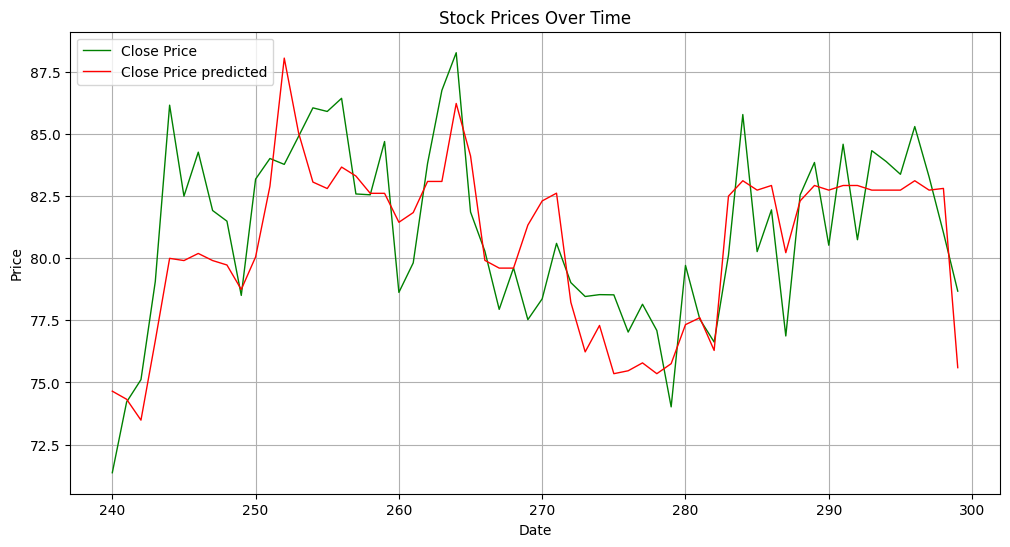

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
y_pred_val_task1 = pd.DataFrame(y_pred_val_task1)
y_pred_val_task1.index = y_val_task1.index
# plt.plot(X_val_task1.index, X_val_task1['Open_Lag1'], label='Open Price', color='blue', linestyle='-', linewidth=1)
plt.plot(y_val_task1.index, y_val_task1, label='Close Price', color='green', linestyle='-', linewidth=1)
plt.plot(y_pred_val_task1.index, y_pred_val_task1, label='Close Price predicted', color='red', linestyle='-', linewidth=1)

plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

plt.show()

<!-- ***INFERENCES***

FROM ABOVE, WE CAN INFER THAT XGBOOST MODEL IS NOT REALLY FITTING THE MODEL TOO WELL, BUT IT IS INDEED ABLE TO GENERALIZE WHEN ENCOUNTERED WITH IMMEDIATE PEAKS AND TROUGHS
-->
*** 

In [59]:
train_data_task1 = feature_engineering_task1(train_data_task1)
X_train_task1 = train_data_task1[['Open_Lag1', 'Open_Lag2','Open_Lag3','EMA_10_2' , 'Rolling_Mean_Open_2','Rolling_Mean_Open_3','Year', 'Open_Diff','Rolling_Mean_Open', 'EMA_10']]
y_train_task1 = train_data_task1['Close']


In [60]:
xgb_regressor_task1 = XGBRegressor(n_estimators=50, max_depth=1,eval_metric = 'mape', learning_rate=0.1, objective='reg:squarederror')
xgb_regressor_task1.fit(X_train_task1, y_train_task1)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mape', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [61]:
test_data_task1 = pd.read_csv('/kaggle/input/ue21cs342aa2/test.csv')

In [62]:
def feature_engineering_test_task1(data):
    data['Open_Lag1'] = data['Open'].shift(3)
    data['Open_Lag2'] = data['Open'].shift(4) 
    data['Open_Lag3'] = data['Open'].shift(2)

    data['Volume_Lag1'] = data['Volume'].shift(-2)


    data['Date'] = pd.to_datetime(data['Date'])

    data['Day'] = data['Date'].dt.day
    data['Month'] = data['Date'].dt.month
    data['Year'] = data['Date'].dt.year

    data['Rolling_Mean_Open'] = data['Open'].rolling(window=4).mean()
    data['Rolling_Mean_Open_2'] = data['Open'].rolling(window=13).mean()
    data['Rolling_Mean_Open_3'] = data['Open'].rolling(window=26).mean()

    data['EMA_10'] = ta.trend.ema_indicator(data['Open'], window=13)
    data['EMA_10_2'] = ta.trend.ema_indicator(data['Open'], window=4)

    data['RSI'] = ta.momentum.RSIIndicator(data['Open']).rsi()

    data['MACD'] = ta.trend.MACD(data['Open']).macd()

    # Add the difference between current and previous Open value
    data['Open_Diff'] = data['Open'] - data['Open'].shift(1)
    data['Open_Diff2'] = data['Open'].shift(1) - data['Open'].shift(2)
    data['Volume_Change'] =  data['Volume'].shift(1) - data['Volume']

    return data

In [63]:
test_data_task1 = feature_engineering_test_task1(test_data_task1)
X_test_task1 = test_data_task1[['Open_Lag1', 'Open_Lag2','Open_Lag3','EMA_10_2' , 'Rolling_Mean_Open_2','Rolling_Mean_Open_3','Year', 'Open_Diff','Rolling_Mean_Open', 'EMA_10']]
y_pred_test_task1 = xgb_regressor_task1.predict(X_test_task1)

## MODEL 3 - XGBOOST CLASSIFIER - CLASSIFICATION

SIMILAR TO XGBOOST REGRESSOR, WE PERFORM FEATURE ENGINEERING, PLAY WITH HYPERPARAMETERS, AND ALSO ACHIEVE A DECENT ACCURACY OF 85% ON THE VALIDATION SET.

also do note that for feature engineering in the XGBoost models, we have dropped year and month, as they did not claim to improve accuracy or smape.

In [64]:
train_data_task2 = pd.read_csv('/kaggle/input/ue21cs342aa2/train.csv')


In [65]:
label_encoder = LabelEncoder()
train_data_task2['Strategy'] = label_encoder.fit_transform(train_data_task2['Strategy'])


In [66]:
def feature_engineering_task2(data):
    data['Open_Lag1'] = data['Open'].shift(3)
    data['Open_Lag2'] = data['Open'].shift(4) 
    data['Open_Lag3'] = data['Open'].shift(2)
    data['Close'] = data['Open'].shift(0)
    data['Close1'] = data['Open'].shift(1)

    data['Volume_Lag1'] = data['Volume'].shift(-2)


    data['Date'] = pd.to_datetime(data['Date'])

    data['Day'] = data['Date'].dt.day
    data['Month'] = data['Date'].dt.month
    data['Year'] = data['Date'].dt.year

    data['Rolling_Mean_Open'] = data['Open'].rolling(window=4).mean()
    data['Rolling_Mean_Open_2'] = data['Open'].rolling(window=13).mean()
    data['Rolling_Mean_Open_3'] = data['Open'].rolling(window=26).mean()

    data['EMA_10'] = ta.trend.ema_indicator(data['Open'], window=13)
    data['EMA_10_2'] = ta.trend.ema_indicator(data['Open'], window=4)

    data['RSI'] = ta.momentum.RSIIndicator(data['Open']).rsi()

    data['MACD'] = ta.trend.MACD(data['Open']).macd()

    # Add the difference between current and previous Open value
    data['Open_Diff'] = data['Open'] - data['Open'].shift(1)
    data['Open_Diff2'] = data['Open'].shift(1) - data['Open'].shift(2)
    data['Volume_Change'] =  data['Volume'].shift(1) - data['Volume']

    return data

train_data_task2 = feature_engineering_task2(train_data_task2)


In [67]:
X_train, X_val, y_train, y_val = train_test_split(
    train_data_task2[['Open_Lag1', 'Open_Lag2', 'Open_Lag3', 'EMA_10_2', 'Close', 'Close1', 'Rolling_Mean_Open_2', 'Rolling_Mean_Open_3', 'Year', 'Open_Diff', 'Rolling_Mean_Open', 'EMA_10']],
    train_data_task2['Strategy'],
    test_size=0.2,
    random_state=42
)


In [68]:
xgb_classifier_task2 = XGBClassifier(n_estimators=50,eval_metric='merror',max_depth=5,tree_method='exact',learning_rate=0.05, objective='multi:softmax',num_class=3)
xgb_classifier_task2.fit(X_train, y_train)
y_val_pred = xgb_classifier_task2.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
accuracy

0.7333333333333333

***WHY ABOVE PARAMETERS WORK??***

1. **n_estimators**:
   
The XGBoost classifier will build 50 decision trees during training, due to which it is better able to capture trends and pattenrs in the data.

2. **eval_metric**:
   
'merror' stands for "Multiclass Classification Error Rate." It measures the classification error for multiclass problems. we have chosen this by carefully going through XGB documentation as we do intend to perform a multiclass classification.

3. **max_depth**:

This parameter controls the maximum depth of each decision tree. A higher value allows the trees to be deeper and potentially more complex. Setting it to 5 limits the depth to 5 levels. This is set to 5 limiting the chances of overfitting despite the large number of estimators used.

4. **tree_method**:

This parameter specifies the method used to build decision trees. 'exact' indicates that exact greedy algorithm is used to build trees.

5. **learning_rate**:
Learning rate is a hyperparameter that controls the step size at each iteration while moving toward a minimum of a loss function. We have set it as 0.05 

6. **objective**:

The 'objective' parameter defines the learning task and the corresponding objective function to be optimized.  'multi:softmax' indicates that the classifier is used for multiclass classification, and it aims to optimize the softmax function.

7. **num_class:**

'num_class' specifies the number of classes or categories in the target variable. We have set it to 3 as the strategy attribute consists of Buy,Sell and Hold as the 3 possible options for a given stock, inorder to better comprehend our data.


***

In [69]:
xgb_classifier_task2.fit(
    train_data_task2[['Open_Lag1', 'Open_Lag2','Open_Lag3', 'EMA_10_2' ,'Close','Close1', 'Rolling_Mean_Open_2','Rolling_Mean_Open_3','Year', 'Open_Diff','Rolling_Mean_Open', 'EMA_10']],
    train_data_task2['Strategy']
)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='merror',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=50, n_jobs=None,
              num_class=3, num_parallel_tree=None, objective='multi:softmax', ...)

In [70]:
test_data_task2 = pd.read_csv('/kaggle/input/ue21cs342aa2/test.csv')
test_data_task2['Close']=y_pred_test_task1

In [71]:
def feature_engineering_test_task2(data):
    data['Open_Lag1'] = data['Open'].shift(3)
    data['Open_Lag2'] = data['Open'].shift(4) 
    data['Open_Lag3'] = data['Open'].shift(2)
    data['Close'] = data['Open'].shift(0)
    data['Close1'] = data['Open'].shift(1)

    data['Volume_Lag1'] = data['Volume'].shift(-2)


    data['Date'] = pd.to_datetime(data['Date'])

    data['Day'] = data['Date'].dt.day
    data['Month'] = data['Date'].dt.month
    data['Year'] = data['Date'].dt.year

    data['Rolling_Mean_Open'] = data['Open'].rolling(window=4).mean()
    data['Rolling_Mean_Open_2'] = data['Open'].rolling(window=13).mean()
    data['Rolling_Mean_Open_3'] = data['Open'].rolling(window=26).mean()

    data['EMA_10'] = ta.trend.ema_indicator(data['Open'], window=13)
    data['EMA_10_2'] = ta.trend.ema_indicator(data['Open'], window=4)

    data['RSI'] = ta.momentum.RSIIndicator(data['Open']).rsi()

    data['MACD'] = ta.trend.MACD(data['Open']).macd()

    # Add the difference between current and previous Open value
    data['Open_Diff'] = data['Open'] - data['Open'].shift(1)
    data['Open_Diff2'] = data['Open'].shift(1) - data['Open'].shift(2)
    data['Volume_Change'] =  data['Volume'].shift(1) - data['Volume']

    return data

In [72]:
test_data_task2 = feature_engineering_test_task2(test_data_task2)
X_test_task2 = test_data_task2[['Open_Lag1', 'Open_Lag2','Open_Lag3', 'EMA_10_2' ,'Close','Close1', 'Rolling_Mean_Open_2','Rolling_Mean_Open_3','Year', 'Open_Diff','Rolling_Mean_Open', 'EMA_10']]
y_pred_test_task2 = xgb_classifier_task2.predict(X_test_task2)
predicted_strategy = label_encoder.inverse_transform(y_pred_test_task2)

In [73]:
test_predictions_task2 = pd.DataFrame({
    'id': test_data_task2['id'],
    'Date': test_data_task2['Date'],
    'Close': test_data_task2['Close'],
    'Strategy': predicted_strategy
})

test_predictions_task2.set_index('id', inplace=True)


In [74]:
test_predictions_task2.to_csv('submission.csv')

***THANK YOU***